In [125]:
#pip install xgboost
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

#model
import xgboost as xgb

In [324]:
### Darts: Time Series Made Easy in Python
from darts import TimeSeries
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode
from darts.metrics import mape
from darts.utils.statistics import plot_residuals_analysis

import optuna

In [206]:
path_weekly = "../../SRAG_time_series/SRAG_TS_weekly.csv"
path_daily = "../../SRAG_time_series/SRAG_TS.csv"

df_weekly  = pd.read_csv(path_weekly, sep=",", encoding="latin-1")
df_daily = pd.read_csv(path_daily, sep=",", encoding="latin-1")

In [214]:
df_weekly["Year_Week"] = pd.to_datetime(df_weekly["Year_Week"])
df_daily["Date"] = pd.to_datetime(df_daily["Date"])
df_weekly = df_weekly.sort_values('Year_Week')

In [210]:
#df_weekly = df_weekly.set_index("Year_Week")
df_weekly.drop(columns=['week'], inplace=True)
df_weekly = df_weekly.iloc[1:]
df_weekly

,Year_Week,Number_Cases
1,2019-01-07,256.0
2,2019-01-14,270.0
3,2019-01-21,273.0
4,2019-01-28,282.0
5,2019-02-04,300.0
...,...,...
313,2024-12-02,4298.0
314,2024-12-09,4284.0
315,2024-12-16,4028.0
316,2024-12-23,4028.0


In [216]:
df_weekly = df_weekly.drop_duplicates(subset='Year_Week', keep='first')

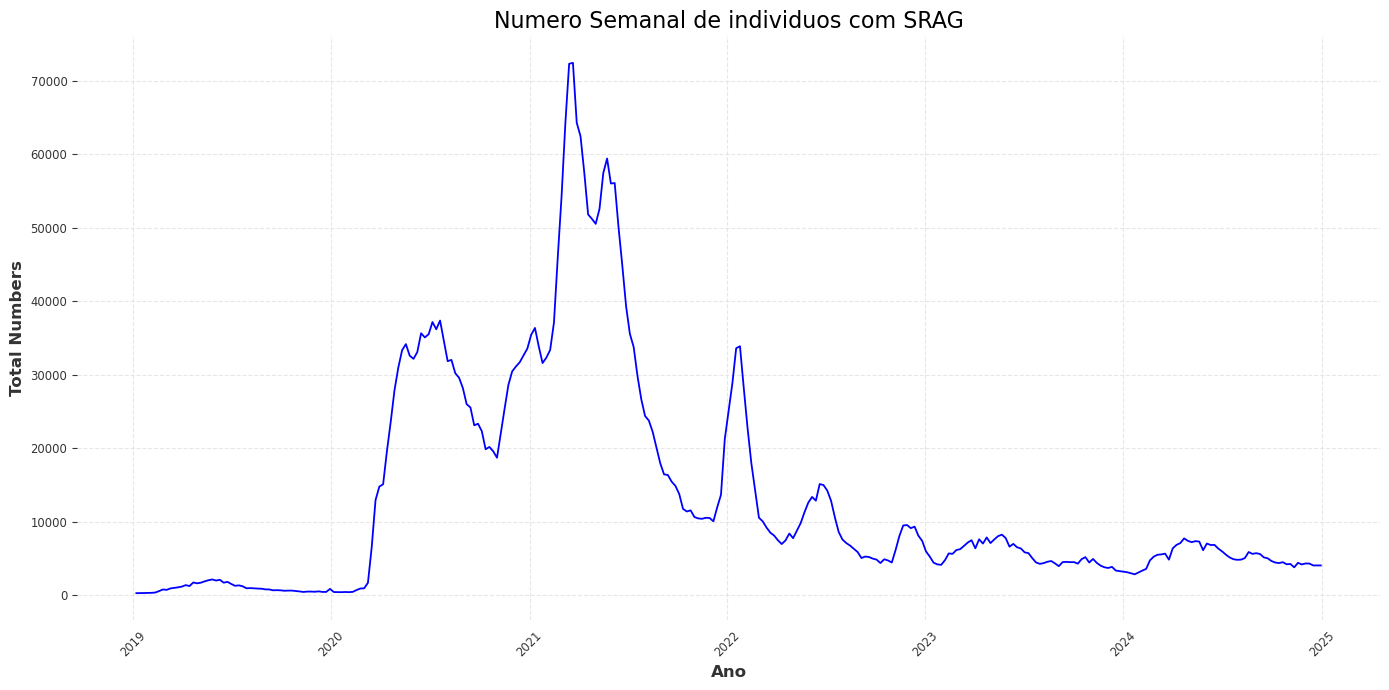

In [242]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_weekly, x='Year_Week', y='Number_Cases', color='b')
#sns.lineplot(data=df_daily, x='Number', y='Number', color='b')


# Customize the plot
plt.title('Numero Semanal de individuos com SRAG', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Total Numbers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Transformando em TimeSeries da darts

In [224]:
full_index = pd.date_range(start=df_weekly['Year_Week'].min(),
                           end=df_weekly['Year_Week'].max(),
                           freq='W-MON')

missing = full_index.difference(df_weekly['Year_Week'])
print("Missing weeks:", missing)


Missing weeks: DatetimeIndex([], dtype='datetime64[ns]', freq='W-MON')


In [226]:
non_mondays = df_weekly[~(df_weekly['Year_Week'].dt.weekday == 0)]
print(non_mondays)

    Year_Week  Number_Cases
53 2020-01-01         414.5


In [228]:
df_weekly['Year_Week'] = df_weekly['Year_Week'] - pd.to_timedelta(df_weekly['Year_Week'].dt.weekday, unit='d')

In [234]:
df_weekly = df_weekly.groupby('Year_Week', as_index=False)['Number_Cases'].sum()

In [236]:
series_weekly = TimeSeries.from_dataframe(
    df_weekly,
    time_col='Year_Week',
    value_cols='Number_Cases',
    fill_missing_dates=True,
    freq='W-MON'
)

<Axes: xlabel='Year_Week'>

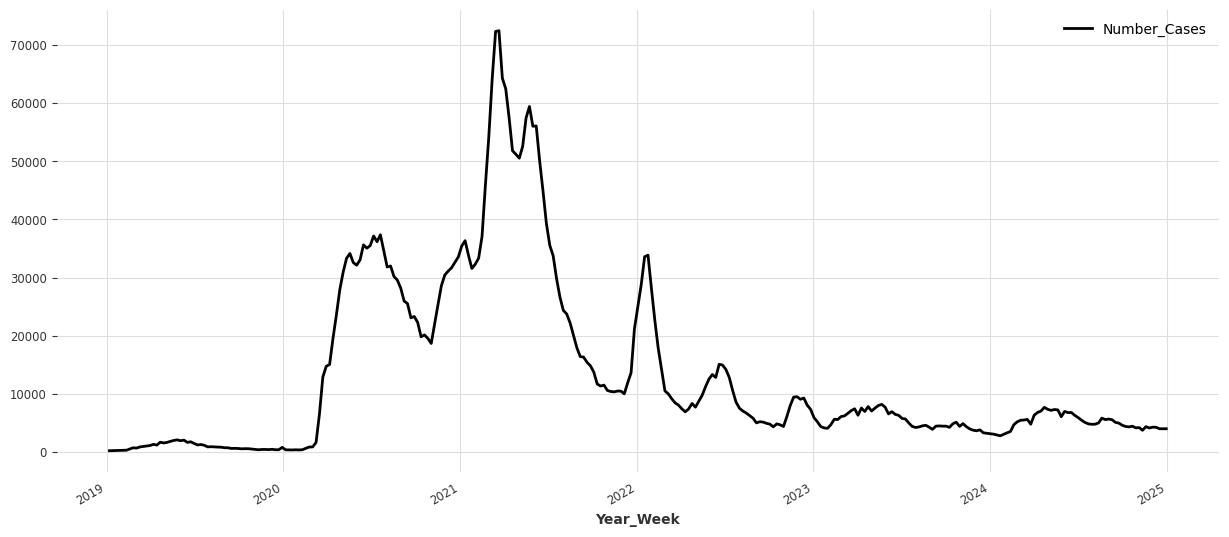

In [240]:
figure = plt.figure(figsize = (15,6))
series_weekly.plot()

### Train Test Split

In [135]:
def train_test_splits(series, train_proportion_list):
    '''
    Funcao para dividir a serie temporal em treino e teste
    
    Parametros:
    
    *series: serie que sera particionada em treino e validacao.
    *train_proportion_list: Lista que define a proporcao do conjunto
    de treinamento. Ex: series_list = [0.8,0.5] significa primeiro conjunto 
    de treino com 80% dos dados totais e o segundo com 50% dos dados totais.
    '''
    partitions_dict = {'train': [], 'test': []}

    for i, train_proportion in enumerate(train_proportion_list):
        train_size = int(len(series) * train_proportion)
        train, test = series.split_before(train_size)
        partitions_dict['train'].append(train)
        partitions_dict['test'].append(test)

        print(f'Partition {i+1} - Train size: {len(train)}, Test size: {len(test)}, Total size: {len(train)+len(test)}')

    return partitions_dict

In [314]:
train_test_df_weekly = train_test_splits(series_weekly, [0.83])

Partition 1 - Train size: 259, Test size: 54, Total size: 313


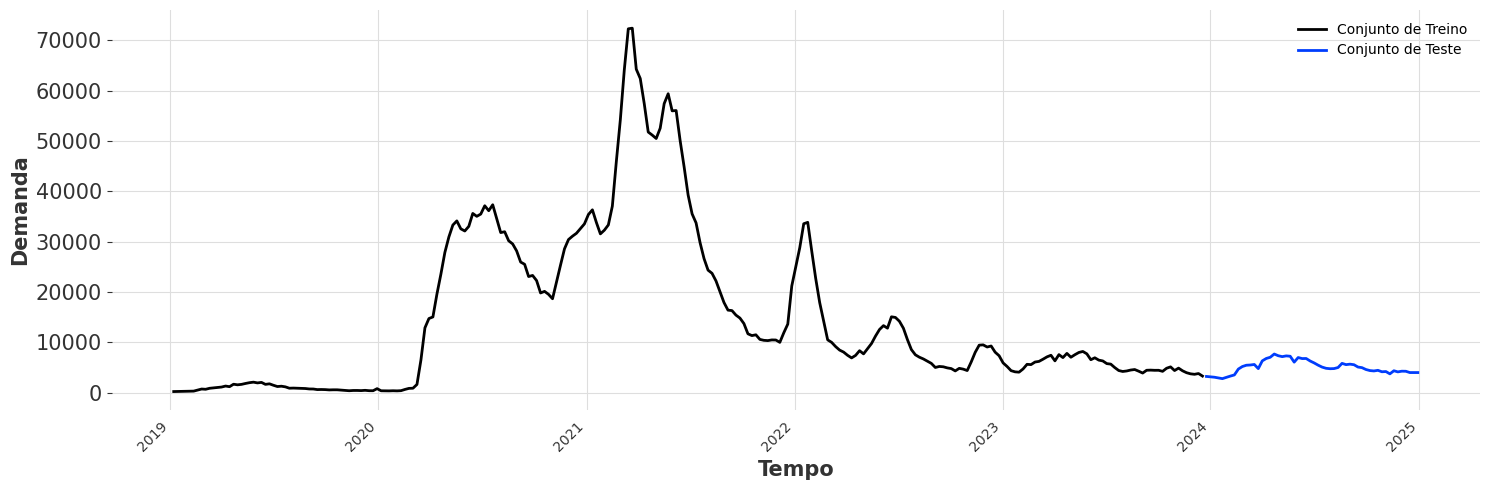

In [320]:
## Plotando
plt.figure(figsize=(15, 5))

train_test_df_weekly['train'][0].plot(label='Conjunto de Treino')

train_test_df_weekly['test'][0].plot(label='Conjunto de Teste')

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=15)
plt.xlabel('Tempo', fontsize=15)
plt.ylabel('Demanda', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

### Setup de treinamento com OPTUNA (XGBoost Model)